In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']


import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
# For time stamps
from datetime import datetime

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Set up End and Start times for data grab
tech_list = ['2382.HK','1299.HK','0388.HK']
# tech_list = ['0002.HK', '0003.HK', '0012.HK', '0017.HK','1398.HK','3988.HK','0669.HK','2382.HK','1299.HK','0388.HK']
# company_name = ['中電', '煤氣', '恒基', '新世界','工商','中國銀行','創科實業','友邦','港交所']
dfs = {}  # 使用字典存储每个股票的数据

for stock in tech_list:
    data = yf.download(stock, "2011-01-01", "2018-12-31")
    dfs[stock] = data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
data = dfs[tech_list[2]].filter(['Close'])

data['chg'] = data.pct_change()
data['nextWeekChg'] = 1/(1+data['Close'].pct_change(-5))
data["signal"] = (data['nextWeekChg'] >1.0)
data.to_csv("temp.csv")

dataset = data.dropna()
x_dataset =dataset.filter(['chg']).values

y_dataset =dataset.filter(['nextWeekChg']).values
training_data_len = int(np.ceil( len(dataset) * .60 ))

scaler = MinMaxScaler(feature_range=(0,1))
x_scaled_data = scaler.fit_transform(x_dataset)
y_scaled_data = scaler.fit_transform(y_dataset)
print("x_train:", x_scaled_data.shape, ", y_train:", y_scaled_data.shape)
print("x_train:", type(x_scaled_data), ", y_train:", type(y_scaled_data))
print("x_train:",x_scaled_data[:2], ", y_train:", y_scaled_data[:2])

x_train: (1964, 1) , y_train: (1964, 1)
x_train: <class 'numpy.ndarray'> , y_train: <class 'numpy.ndarray'>
x_train: [[0.44310616]
 [0.33118796]] , y_train: [[0.31129806]
 [0.35297018]]


In [4]:
dataset


,Close,chg,nextWeekChg,signal
Date,,,,
2011-01-04,185.600006,0.032258,0.984914,False
2011-01-05,185.600006,0.000000,1.017241,True
2011-01-06,184.800003,-0.004310,1.023268,True
2011-01-07,184.800003,0.000000,1.013528,True
2011-01-10,182.199997,-0.014069,1.018112,True
...,...,...,...,...
2018-12-13,234.199997,0.018261,0.971819,False
2018-12-14,232.199997,-0.008540,0.982773,False
2018-12-17,231.199997,-0.004307,0.984429,False


In [5]:
window = 15 #before w to now day
train_data = x_scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(window, len(train_data)):
    x_train.append(x_scaled_data[i-window:i, 0])
    y_train.append(y_scaled_data[i, 0])
        
# # Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# # Reshape the data
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# # x_train.shape
   
print("x_train:", x_train.shape, ", output:", y_train.shape)


x_train: (1164, 15, 1) , output: (1164,)


Epoch 1/10


c:\Users\bruce\anaconda3\envs\trading\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


233/233 [==============================] - 4s 6ms/step - loss: 0.0750
Epoch 2/10
233/233 [==============================] - 1s 6ms/step - loss: 0.0457
Epoch 3/10
233/233 [==============================] - 1s 6ms/step - loss: 0.0231
Epoch 4/10
233/233 [==============================] - 1s 6ms/step - loss: 0.0098
Epoch 5/10
233/233 [==============================] - 1s 6ms/step - loss: 0.0050
Epoch 6/10
233/233 [==============================] - 1s 6ms/step - loss: 0.0042
Epoch 7/10
233/233 [==============================] - 1s 6ms/step - loss: 0.0041
Epoch 8/10
233/233 [==============================] - 1s 6ms/step - loss: 0.0041
Epoch 9/10
233/233 [==============================] - 1s 6ms/step - loss: 0.0041
Epoch 10/10
233/233 [==============================] - 1s 6ms/step - loss: 0.0041


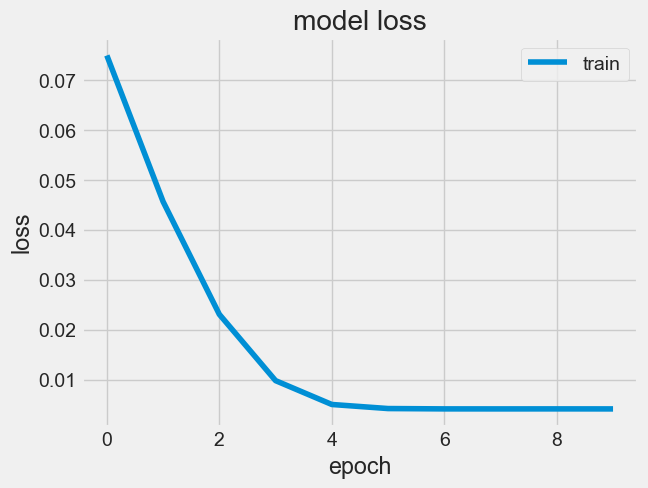

In [6]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape= (x_train.shape[1], 1)))

model.add(LSTM(16, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))


# Compile the model
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(x_train, y_train, batch_size=5, epochs=10)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [7]:
Ytest_data = y_scaled_data[training_data_len : , :]
Xtest_data = y_scaled_data[training_data_len : , :]
# Create the data sets x_test and y_test
x_test = []

y_test = dataset[["nextWeekChg"]][training_data_len:-window]
for i in range(window, len(Xtest_data)):
    x_test.append(Xtest_data[i-window:i, 0])
# Convert the data to a numpy array
x_test = np.array(x_test)
x_test.shape, y_test.shape

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

print("x_test:", x_test.shape, ", output:", y_test.shape)
print("x_test:", type(x_test), ", output:", type(y_test))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse



x_test: (770, 15, 1) , output: (770, 1)
x_test: <class 'numpy.ndarray'> , output: <class 'pandas.core.frame.DataFrame'>
25/25 [==============================] - 1s 2ms/step


0.034276743703101346

C:\Users\bruce\AppData\Local\Temp\ipykernel_17472\194574295.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["predictChg"] = predictions
C:\Users\bruce\AppData\Local\Temp\ipykernel_17472\194574295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["PredClose"]  = valid["Close"] *valid["predictChg"]


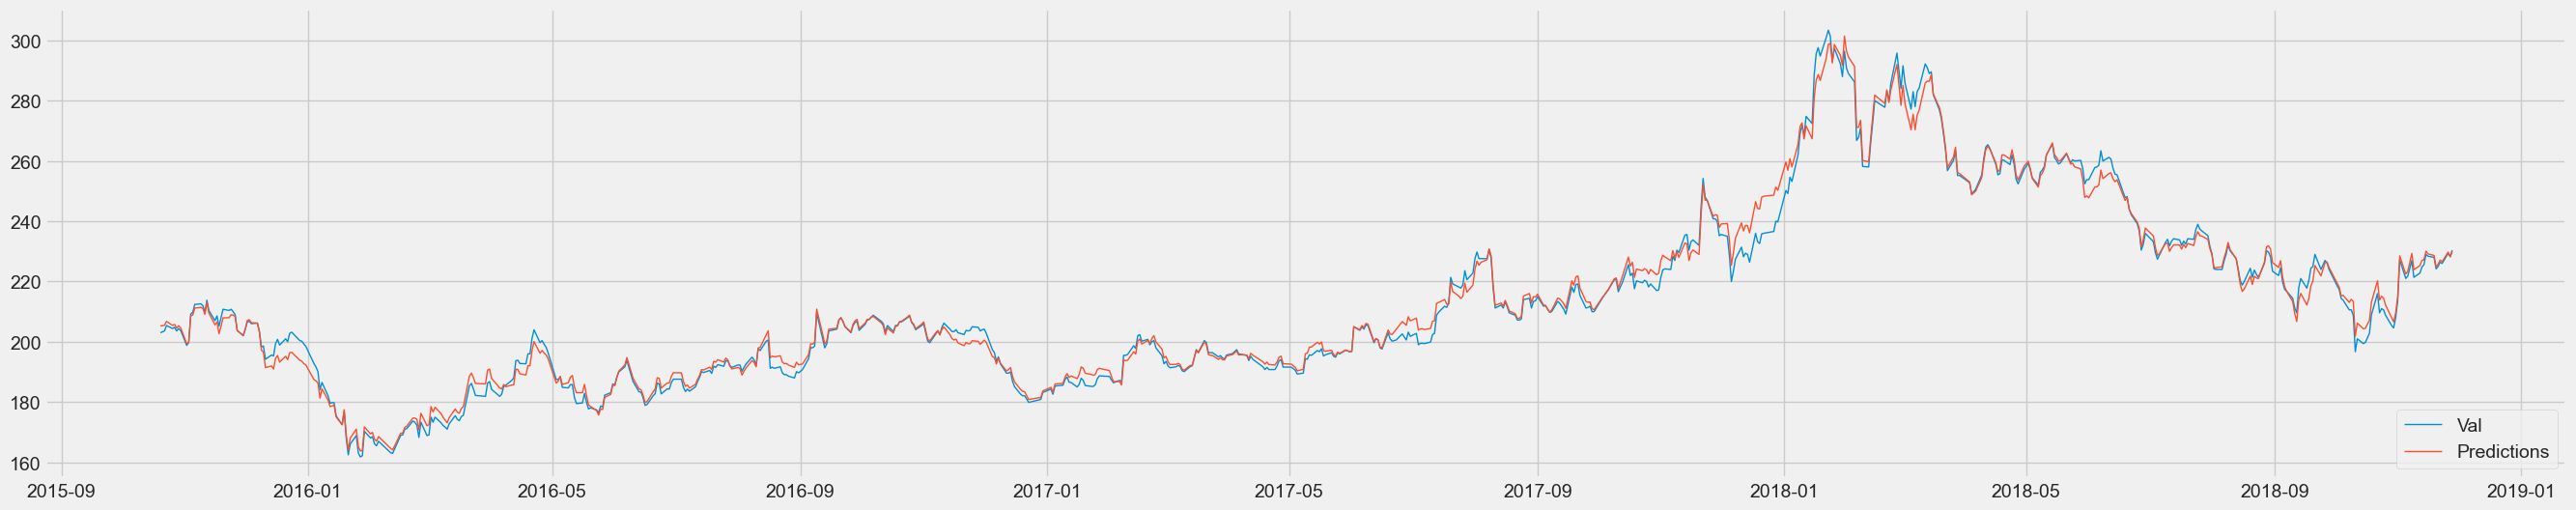

In [8]:
valid = dataset[training_data_len:-window]
valid["predictChg"] = predictions
valid
valid["PredClose"]  = valid["Close"] *valid["predictChg"]
plt.figure(figsize=(30,6))
plt.plot(valid[['Close', 'PredClose']],linewidth=1)
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()


In [9]:
df = pd.DataFrame()

In [10]:
df =valid
df["Predict"]= (df['predictChg'] > 1.0).astype(int)
df.to_csv("temp.csv")
count = valid["Predict"].sum()

C:\Users\bruce\AppData\Local\Temp\ipykernel_17472\1025578240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Predict"]= (df['predictChg'] > 1.0).astype(int)


In [11]:
tp = ((df['signal'] == 1) & (df['Predict'] == 1)).sum()
tn = ((df['signal'] == 0) & (df['Predict'] == 0)).sum()
fp = ((df['signal'] == 0) & (df['Predict'] == 1)).sum()
fn = ((df['signal'] == 1) & (df['Predict'] == 0)).sum()
tp, tn ,fp,fn

(272, 138, 224, 136)

In [12]:
df

,Close,chg,nextWeekChg,signal,predictChg,PredClose,Predict
Date,,,,,,,
2015-10-20,203.000000,-0.011684,1.002956,True,1.011164,205.266209,1
2015-10-22,203.600006,0.002956,1.003929,True,1.009107,205.454190,1
2015-10-23,205.399994,0.008841,0.992210,False,1.006653,206.766583,1
2015-10-26,204.399994,-0.004869,0.972603,False,1.005065,205.435199,1
2015-10-27,204.800003,0.001957,0.975586,False,1.004716,205.765897,1
...,...,...,...,...,...,...,...
2018-11-22,226.399994,0.006222,1.007951,True,1.003199,227.124270,1
2018-11-23,226.000000,-0.001767,1.008850,True,1.002584,226.583872,1
2018-11-26,229.399994,0.015044,1.024412,True,1.001594,229.765591,1


In [13]:
for i in range(0,5):
    df[f"d_{i}"]  =df.Predict.shift(i)
df

C:\Users\bruce\AppData\Local\Temp\ipykernel_17472\3642854561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"d_{i}"]  =df.Predict.shift(i)
C:\Users\bruce\AppData\Local\Temp\ipykernel_17472\3642854561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"d_{i}"]  =df.Predict.shift(i)
C:\Users\bruce\AppData\Local\Temp\ipykernel_17472\3642854561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,Close,chg,nextWeekChg,signal,predictChg,PredClose,Predict,d_0,d_1,d_2,d_3,d_4
Date,,,,,,,,,,,,
2015-10-20,203.000000,-0.011684,1.002956,True,1.011164,205.266209,1,1,NaN,NaN,NaN,NaN
2015-10-22,203.600006,0.002956,1.003929,True,1.009107,205.454190,1,1,1.0,NaN,NaN,NaN
2015-10-23,205.399994,0.008841,0.992210,False,1.006653,206.766583,1,1,1.0,1.0,NaN,NaN
2015-10-26,204.399994,-0.004869,0.972603,False,1.005065,205.435199,1,1,1.0,1.0,1.0,NaN
2015-10-27,204.800003,0.001957,0.975586,False,1.004716,205.765897,1,1,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-22,226.399994,0.006222,1.007951,True,1.003199,227.124270,1,1,1.0,1.0,1.0,1.0
2018-11-23,226.000000,-0.001767,1.008850,True,1.002584,226.583872,1,1,1.0,1.0,1.0,1.0
2018-11-26,229.399994,0.015044,1.024412,True,1.001594,229.765591,1,1,1.0,1.0,1.0,1.0


In [14]:
df = df.dropna() 
df

,Close,chg,nextWeekChg,signal,predictChg,PredClose,Predict,d_0,d_1,d_2,d_3,d_4
Date,,,,,,,,,,,,
2015-10-27,204.800003,0.001957,0.975586,False,1.004716,205.765897,1,1,1.0,1.0,1.0,1.0
2015-10-28,203.600006,-0.005859,1.027505,True,1.004736,204.564318,1,1,1.0,1.0,1.0,1.0
2015-10-29,204.399994,0.003929,1.026419,True,1.004498,205.319337,1,1,1.0,1.0,1.0,1.0
2015-10-30,203.800003,-0.002935,1.042198,True,1.004303,204.676853,1,1,1.0,1.0,1.0,1.0
2015-11-02,198.800003,-0.024534,1.069417,True,1.002773,199.351356,1,1,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-22,226.399994,0.006222,1.007951,True,1.003199,227.124270,1,1,1.0,1.0,1.0,1.0
2018-11-23,226.000000,-0.001767,1.008850,True,1.002584,226.583872,1,1,1.0,1.0,1.0,1.0
2018-11-26,229.399994,0.015044,1.024412,True,1.001594,229.765591,1,1,1.0,1.0,1.0,1.0


In [15]:
df.columns

Index(['Close', 'chg', 'nextWeekChg', 'signal', 'predictChg', 'PredClose',
       'Predict', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4'],
      dtype='object')

In [16]:
df["sum"] =df[['d_0','d_1', 'd_2', 'd_3', 'd_4']].sum(axis=1)

C:\Users\bruce\AppData\Local\Temp\ipykernel_17472\89111164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sum"] =df[['d_0','d_1', 'd_2', 'd_3', 'd_4']].sum(axis=1)


In [17]:
df.to_csv("ppp.csv")